<a href="https://colab.research.google.com/github/nguyenkimthach/Optimization_Binary_Neural_Network/blob/main/Binary_train_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#dataset_path = '/content/drive/MyDrive/newdataset/'
train_path='/content/newdataset/train'
test_path='/content/newdataset/test'


In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kimthchnguyn/newdataset
!unzip -uq "/content/newdataset.zip"


Saving kaggle.json to kaggle.json
 85% 11.0M/13.0M [00:00<00:00, 51.4MB/s]
100% 13.0M/13.0M [00:00<00:00, 55.6MB/s]


In [ ]:
!pip install numpy==1.19.5
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
xarray-einstats 0.5.1 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.11.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
matplotlib 3.7.1 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
librosa 0.10.0.post2 requires numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3, but you have numpy 1.19.5 which is incompatible.
jaxlib 0.4.6+cu

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install larq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 3.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import larq as lq
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
from sklearn import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.utils import np_utils
print(tf.__version__)

2.7.0


In [ ]:
def convert_to_binary(img_grayscale, thresh=100):
    thresh, img_binary = cv2.threshold(img_grayscale, thresh, maxval=255, type=cv2.THRESH_BINARY)
    return img_binary

In [ ]:
data = []
labels = []

imagePaths = list(paths.list_images(train_path))
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath, 0)
    image = convert_to_binary(image, thresh=150)
    image = cv2.resize(image, (64, 64))
    # image = image/255.0
    # fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
    #                 cells_per_block=(1, 1), visualize=True, multichannel=True)
    # print(image)
    data.append(image)
    labels.append(label)
#print(labels)
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
#print(labels)

data = np.array(data)
x_train = data.astype('float32')

x_train /= 255
y_train = np_utils.to_categorical(labels, 3)

#print(y_train)
img_width, img_height = 64, 64

train_data_dir = 'data/train'
#validation_data_dir = 'data/test'
nb_train_samples = 330
nb_validation_samples = 60


In [ ]:
data = []
labels = []

imagePaths = list(paths.list_images(test_path))
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath, 0)
    image = convert_to_binary(image, thresh=150)
    image = cv2.resize(image, (64, 64))
    # image = image/255.0
    # fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
    #                 cells_per_block=(1, 1), visualize=True, multichannel=True)
    # print(image)
    data.append(image)
    labels.append(label)
#print(labels)
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
#print(labels)

data = np.array(data)
x_test = data.astype('float32')

x_test /= 255
y_test = np_utils.to_categorical(labels, 3)

#print(y_train)
img_width, img_height = 64, 64

#train_data_dir = 'data/train'
validation_data_dir = 'data/test'
nb_train_samples = 330
nb_validation_samples = 60

print(x_train.shape )
print(x_test.shape )
print(y_train.shape )
print(y_test.shape )

(4990, 64, 64)
(303, 64, 64)
(4990, 3)
(303, 3)


In [ ]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(64, 64, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(3, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

In [ ]:
lq.models.summary(model)

+sequential stats---------------------------------------------------------------------------------------------+
| Layer                  Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                              (bit)                          x 1       x 1     (kB)                          |
+-------------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 62, 62, 128)      1152         0     0.14           0      4428288 |
| batch_normalization              -  (-1, 62, 62, 128)         0       256     1.00           0            0 |
| quant_conv2d_1                   1  (-1, 62, 62, 128)    147456         0    18.00   566820864            0 |
| max_pooling2d                    -  (-1, 31, 31, 128)         0         0        0           0            0 |
| batch_normalization_1            -  (-1, 31, 31, 128)         0       256     1.00           0        

In [ ]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
trained_model = model.fit(
    x_train,
    y_train,
    batch_size=15,
    epochs=2,
    validation_data=(x_test, y_test),
    shuffle=True
)

Epoch 1/50
333/333 [==============================] - 32s 55ms/step - loss: 0.8122 - accuracy: 0.6471 - val_loss: 3.3721 - val_accuracy: 0.3333
Epoch 2/50
333/333 [==============================] - 16s 48ms/step - loss: 0.3340 - accuracy: 0.9425 - val_loss: 2.0804 - val_accuracy: 0.3333
Epoch 3/50
333/333 [==============================] - 16s 48ms/step - loss: 0.2887 - accuracy: 0.9737 - val_loss: 1.7698 - val_accuracy: 0.3333
Epoch 4/50
333/333 [==============================] - 16s 49ms/step - loss: 0.2723 - accuracy: 0.9868 - val_loss: 1.6645 - val_accuracy: 0.3333
Epoch 5/50
333/333 [==============================] - 17s 51ms/step - loss: 0.2729 - accuracy: 0.9842 - val_loss: 1.6119 - val_accuracy: 0.3333
Epoch 6/50
333/333 [==============================] - 16s 49ms/step - loss: 0.2691 - accuracy: 0.9868 - val_loss: 1.5266 - val_accuracy: 0.3333
Epoch 7/50
333/333 [==============================] - 16s 49ms/step - loss: 0.2681 - accuracy: 0.9904 - val_loss: 1.3175 - val_accuracy:

In [ ]:
#save mode
model.save('my_model_dataset.h5_new_100')

0.9993987679481506
1.0


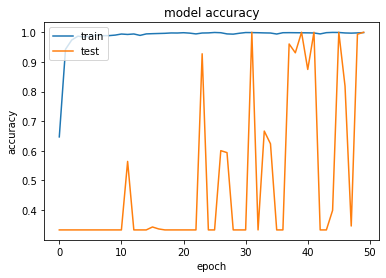

In [ ]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.25301453471183777
0.23578494787216187


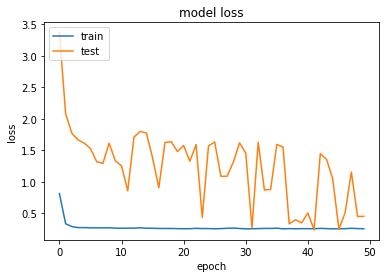

In [ ]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))